In [28]:
import os
import shutil
dirpath = os.path.join('.', 'video_to_frame')
if os.path.exists(dirpath) and os.path.isdir(dirpath):
    shutil.rmtree(dirpath)

pd='./'   
d='video_to_frame'                                      
path = os.path.join(pd, d) 
os.mkdir(path)

dirpath = os.path.join('.', 'cropped')
if os.path.exists(dirpath) and os.path.isdir(dirpath):
    shutil.rmtree(dirpath)

pd='./'   
d='cropped'                                     
path = os.path.join(pd, d) 
os.mkdir(path)

dirpath = os.path.join('.', 'test_imgs_output')
if os.path.exists(dirpath) and os.path.isdir(dirpath):
    shutil.rmtree(dirpath)

pd='./'   
d='test_imgs_output'                                         
path = os.path.join(pd, d) 
os.mkdir(path)

dirpath = os.path.join('.', 'segment')
if os.path.exists(dirpath) and os.path.isdir(dirpath):
    shutil.rmtree(dirpath)


In [29]:
import cv2
import os
import glob
vidcap = cv2.VideoCapture('./videos/1/2019_0709_111000_119A.MP4_60_62_.MP4') 
def getFrame(sec):
    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*500)
    hasFrames,image = vidcap.read()
    if hasFrames:
        cv2.imwrite("./video_to_frame/"+str(count)+".jpg", image)  
    return hasFrames
sec = 0
frameRate = 1
count=1
success = getFrame(sec)

while success:
    count = count + 1
    sec = sec + frameRate
    sec = round(sec, 2)
    success = getFrame(sec)


In [30]:

folder1='./video_to_frame/'
folder='./test_imgs_output/'
for filename in os.listdir(folder1):
    img = cv2.imread(os.path.join(folder1,filename))
    img = img[660:790,750:1250]
    dst = cv2.detailEnhance(img, sigma_r=50, sigma_s=0.7)
    cv2.imwrite(folder+filename,dst)

In [3]:
import cv2
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image
import os

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    

    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
    return img

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)

def read_img(img):
    return mpimg.imread(img)

def to_hls(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

def to_hsv(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

def isolate_color_mask(img, low_thresh, high_thresh):
    assert(low_thresh.all() >=0  and low_thresh.all() <=255)
    assert(high_thresh.all() >=0 and high_thresh.all() <=255)
    return cv2.inRange(img, low_thresh, high_thresh)

def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
 
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

def save_imgs(img_list, labels, prefix="Test", op_folder="test_imgs_output"):
    if not os.path.exists(op_folder):
        os.mkdir(op_folder)
    for img, label in zip(img_list, labels):
        PATH = op_folder + "/" + prefix + "" + label
        Image.fromarray(img).save(PATH)

def display_imgs(img_list, labels=[],cols=2, fig_size=(15,15)):
    if len(labels) > 0:
        assert(len(img_list) == len(labels))
    assert(len(img_list) > 0)
    cmap = None
    tot = len(img_list)
    rows = tot / cols
    plt.figure(figsize=fig_size)
    for i in range(tot):
        plt.subplot(rows, cols, i+1)
        if len(img_list[i].shape) == 2:
            cmap = 'gray'
        if len(labels) > 0:
            plt.title(labels[i])
        plt.imshow(img_list[i], cmap=cmap)
        
    plt.tight_layout()
    plt.show()

def get_aoi(img):
    rows, cols = img.shape[:2]
    mask = np.zeros_like(img)
    
    left_bottom = [cols * 0.1, rows]
    right_bottom = [cols * 0.95, rows]
    left_top = [cols * 0.4, rows * 0.6]
    right_top = [cols * 0.6, rows * 0.6]
    
    vertices = np.array([[left_bottom, left_top, right_top, right_bottom]], dtype=np.int32)
    
    if len(mask.shape) == 2:
        cv2.fillPoly(mask, vertices, 255)
    else:
        cv2.fillPoly(mask, vertices, (255, ) * mask.shape[2])
    return cv2.bitwise_and(img, mask)

def get_hough_lines(img, rho=1, theta=np.pi/180, threshold=20, min_line_len=20, max_line_gap=250):
    
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), 
                            minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    return lines

def get_line_length(line):
    for x1, y1, x2, y2 in line:
        return np.sqrt((y2-y1)**2 + (x2-x1)**2)

def get_line_slope_intercept(line):
    for x1, y1, x2, y2 in line:
        if x2-x1 == 0:
            return math.inf, 0
    slope = (y2-y1)/(x2-x1)
    intercept = y1 - slope * x1
    return slope, intercept
        
def get_lines_slope_intecept(lines):
    left_lines = []
    right_lines = []
    left_lengths = []
    right_lengths = []
    for line in lines:
        slope, intercept = get_line_slope_intercept(line)
        if slope == math.inf:
            continue
        line_len = get_line_length(line)
        if slope < 0:
            left_lines.append((slope, intercept))
            left_lengths.append(line_len)
        else :
            right_lines.append((slope, intercept))
            right_lengths.append(line_len)
            
    # average
    left_avg = np.dot(left_lengths, left_lines)/np.sum(left_lengths) if len(left_lengths) > 0 else None
    right_avg = np.dot(right_lengths, right_lines)/np.sum(right_lengths) if len(right_lengths) > 0 else None
    
    return left_avg, right_avg

def convert_slope_intercept_to_line(y1, y2 , line):
    if line is None:
        return None
    
    slope, intercept = line
    x1 = int((y1- intercept)/slope)
    y1 = int(y1)
    x2 = int((y2- intercept)/slope)
    y2 = int(y2)
    return((x1, y1),(x2, y2))

def get_lane_lines(img, lines):
    left_avg, right_avg = get_lines_slope_intecept(lines)
    
    y1 = img.shape[0]
    y2 = img.shape[0] * 0.6
    
    left_lane = convert_slope_intercept_to_line(y1, y2, left_avg)
    right_lane = convert_slope_intercept_to_line(y1, y2, right_avg)
    return left_lane, right_lane

def draw_weighted_lines(img, lines, color=[255, 0, 0], thickness=2, alpha = 1.0, beta = 0.95, gamma= 0):
    mask_img = np.zeros_like(img)
    for line in lines:
        if line is not None:
            cv2.line(mask_img, *line, color, thickness)            
    return weighted_img(mask_img, img, alpha, beta, gamma)

In [4]:
from collections import deque
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os


class LaneMemory:
    def __init__(self, max_entries=50):
        self.max_entries = max_entries
        self.left_lanes = deque(maxlen=self.max_entries)
        self.right_lanes = deque(maxlen=self.max_entries)
        
    def process(self, img):
        result, left_lane , right_lane = process_image(img, calc_mean=True, left_mem= self.left_lanes, right_mem = self.right_lanes)
        self.left_lanes.append(left_lane)
        self.right_lanes.append(right_lane)
        return result


def process_image(image, calc_mean=False, **kwargs):
    if calc_mean:
        assert('left_mem' in kwargs.keys())
        assert('right_mem' in kwargs.keys())
    
    original_img = np.copy(image)
    
    # convert to grayscale
    gray_img = grayscale(image)
    
    # darken the grayscale
    darkened_img = adjust_gamma(gray_img, 0.5)
    
    # Color Selection
    white_mask = isolate_color_mask(to_hls(image), np.array([0, 200, 0], dtype=np.uint8), np.array([200, 255, 255], dtype=np.uint8))
    yellow_mask = isolate_color_mask(to_hls(image), np.array([10, 0, 100], dtype=np.uint8), np.array([40, 255, 255], dtype=np.uint8))
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    colored_img = cv2.bitwise_and(darkened_img, darkened_img, mask=mask)
    
    # Apply Gaussian Blur
    blurred_img = gaussian_blur(colored_img, kernel_size=7)
    
    # Apply Canny edge filter
    canny_img = canny(blurred_img, low_threshold=70, high_threshold=140)
    
    # Get Area of Interest
    aoi_img = get_aoi(canny_img)
    
    # Apply Hough lines
    hough_lines = get_hough_lines(aoi_img)
    hough_img = draw_lines(original_img, hough_lines)
    
    # Extrapolation and averaging
    left_lane, right_lane = get_lane_lines(original_img, hough_lines)
    
    if calc_mean:
        if left_lane is not None and right_lane is not None:
            kwargs['left_mem'].append(left_lane)
            kwargs['right_mem'].append(right_lane)
        left_mean = np.mean(kwargs['left_mem'], axis=0, dtype=np.int32)
        right_mean = np.mean(kwargs['right_mem'], axis=0, dtype=np.int32)
        left_lane_avg = tuple(map(tuple, left_mean))
        right_lane_avg = tuple(map(tuple, right_mean))
        result = draw_weighted_lines(original_img, [left_lane_avg, right_lane_avg], thickness= 10)
        return result, left_lane, right_lane
    
    result = draw_weighted_lines(original_img, [left_lane, right_lane], thickness= 10)
       
    return result, left_lane, right_lane


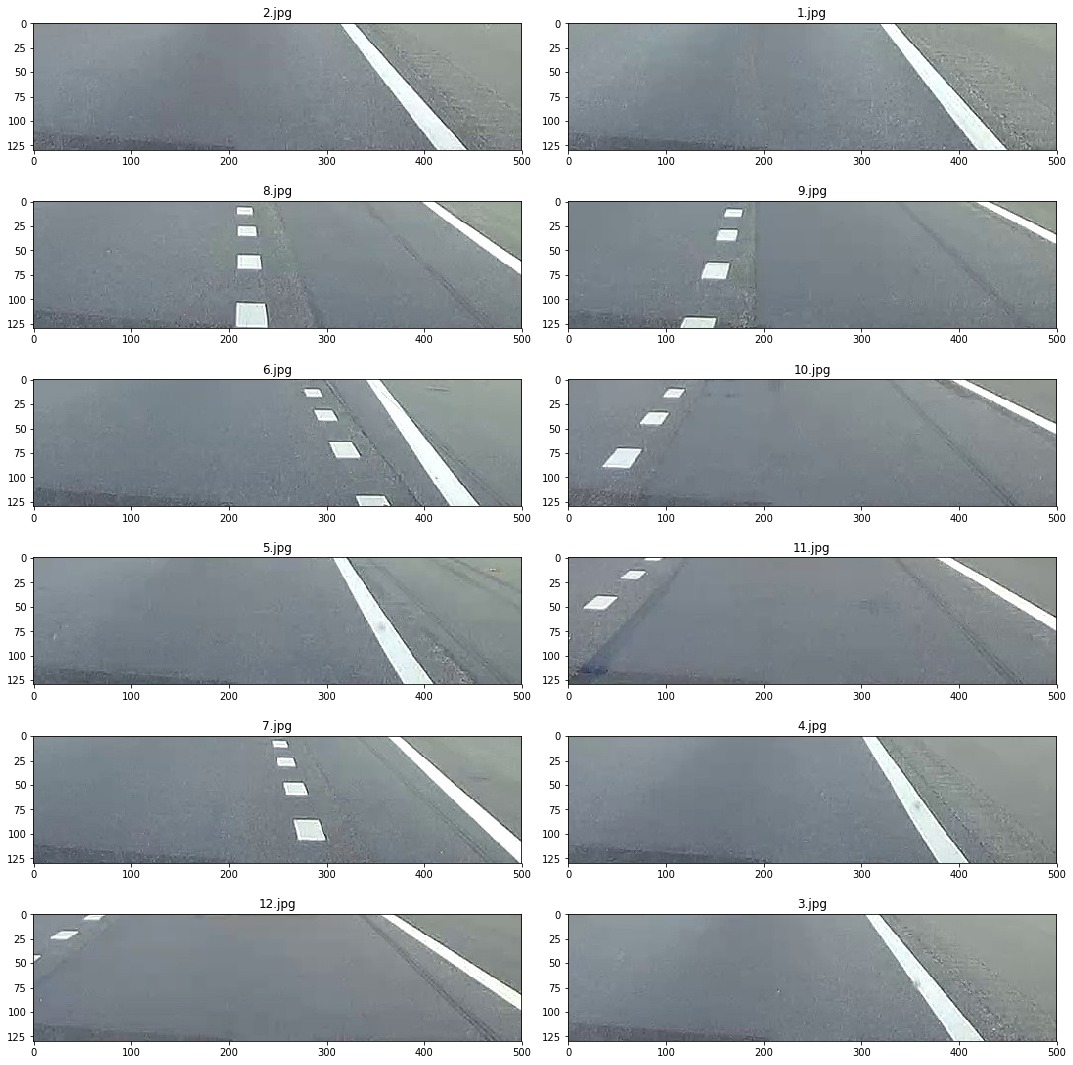

In [5]:
PATH = "test_imgs_output"
test_imgs = os.listdir(PATH)
img_list = [read_img(PATH +"/" + name) for name in test_imgs]
display_imgs(img_list, test_imgs)
save_imgs(img_list, test_imgs, prefix= "")

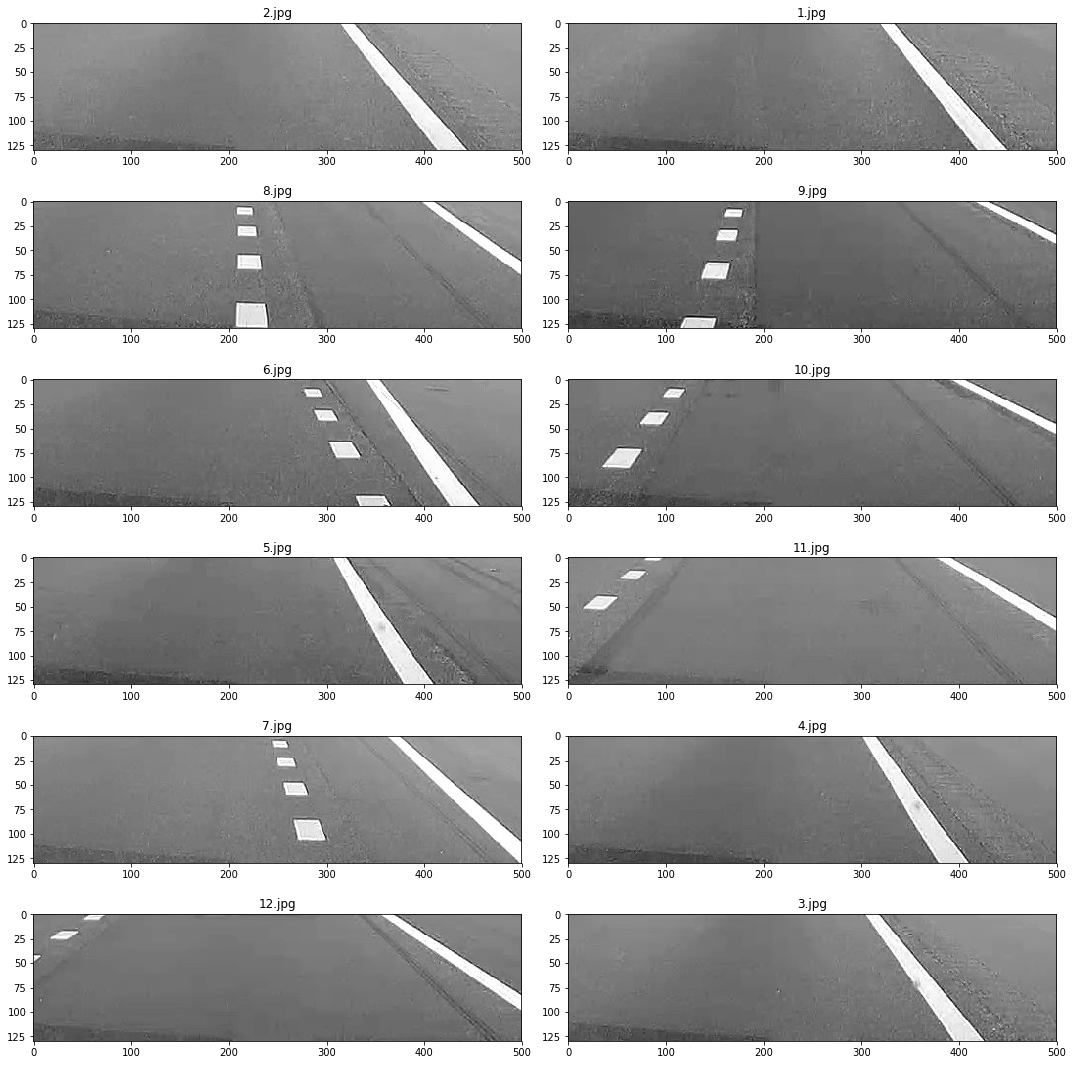

In [6]:
original_imgs = np.copy(img_list)
gray_imgs = [grayscale(img) for img in img_list]
display_imgs(gray_imgs, test_imgs)
save_imgs(gray_imgs, test_imgs, prefix="")

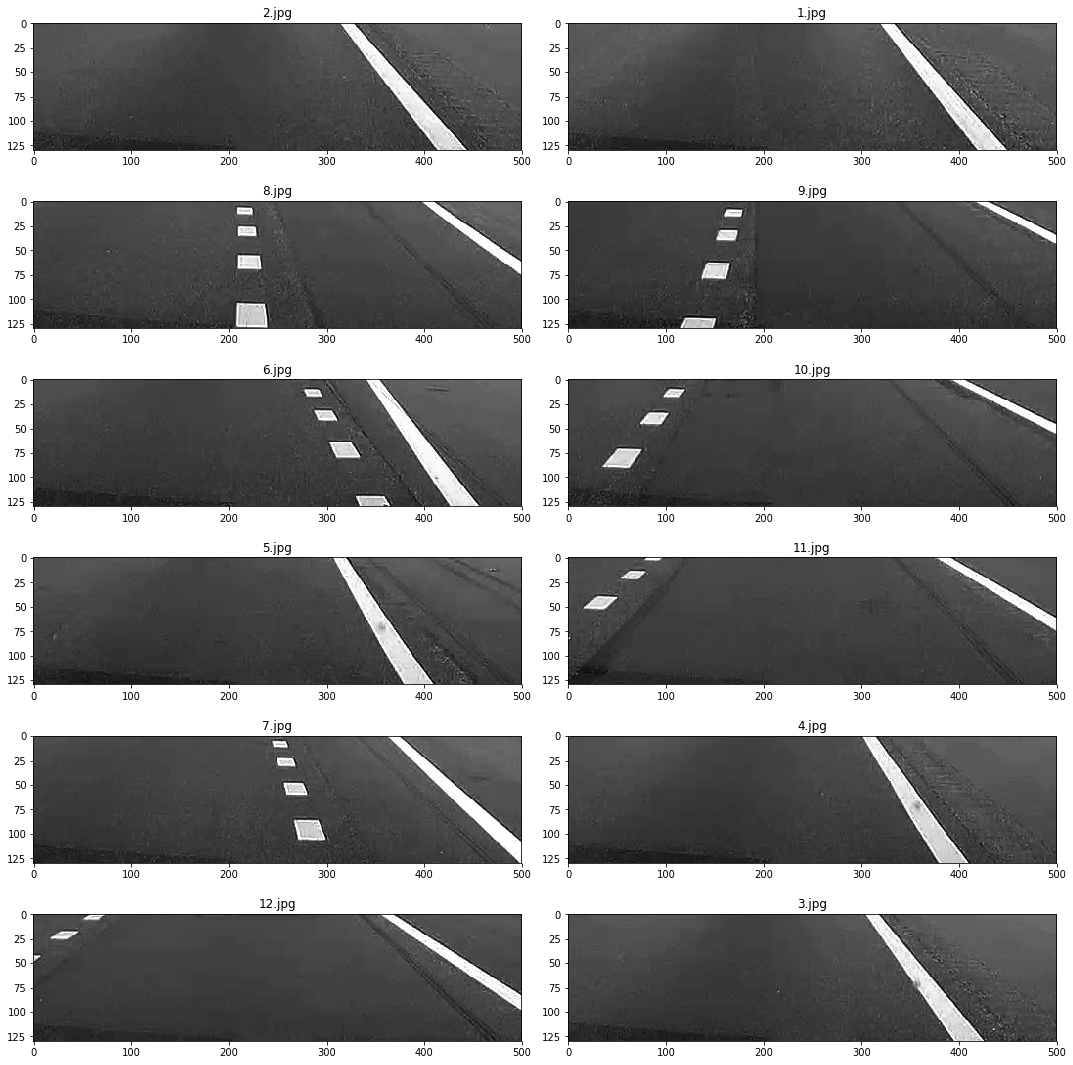

In [7]:
darkened_imgs = [adjust_gamma(img, 0.5) for img in gray_imgs]
display_imgs(darkened_imgs, test_imgs)
save_imgs(darkened_imgs, test_imgs, prefix="")

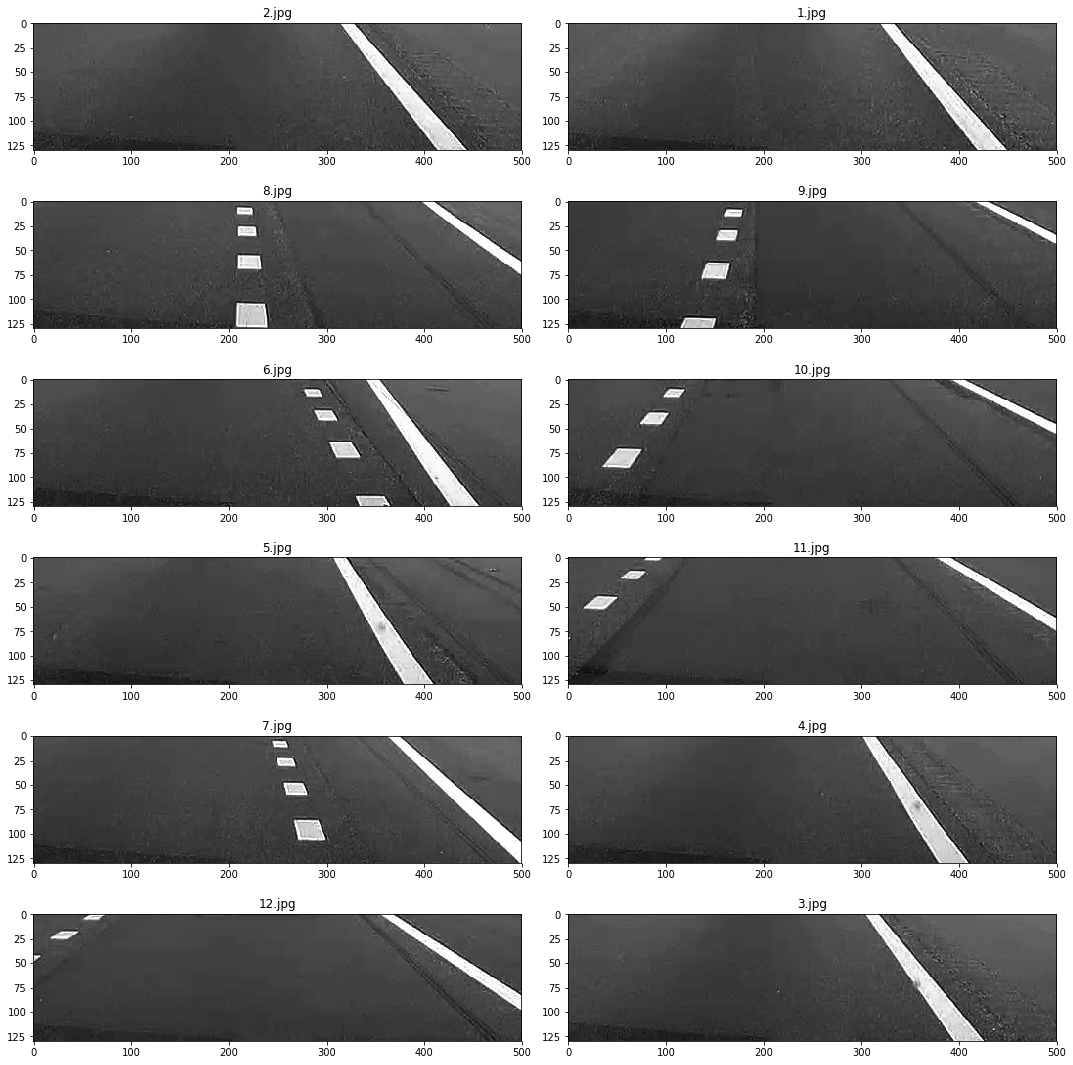

In [8]:
white_masks = [isolate_color_mask(img, np.array([10,10,10], dtype=np.uint8), np.array([255, 255, 255], dtype=np.uint8)) for img in img_list]
yellow_masks = [isolate_color_mask(img, np.array([190, 190, 0], dtype=np.uint8), np.array([255, 255, 255], dtype=np.uint8)) for img in img_list]
masked_imgs = []
for i in range(len(img_list)):
    mask = cv2.bitwise_or(white_masks[i], yellow_masks[i])
    masked_imgs.append(cv2.bitwise_and(darkened_imgs[i], darkened_imgs[i], mask=mask))

display_imgs(masked_imgs, test_imgs)

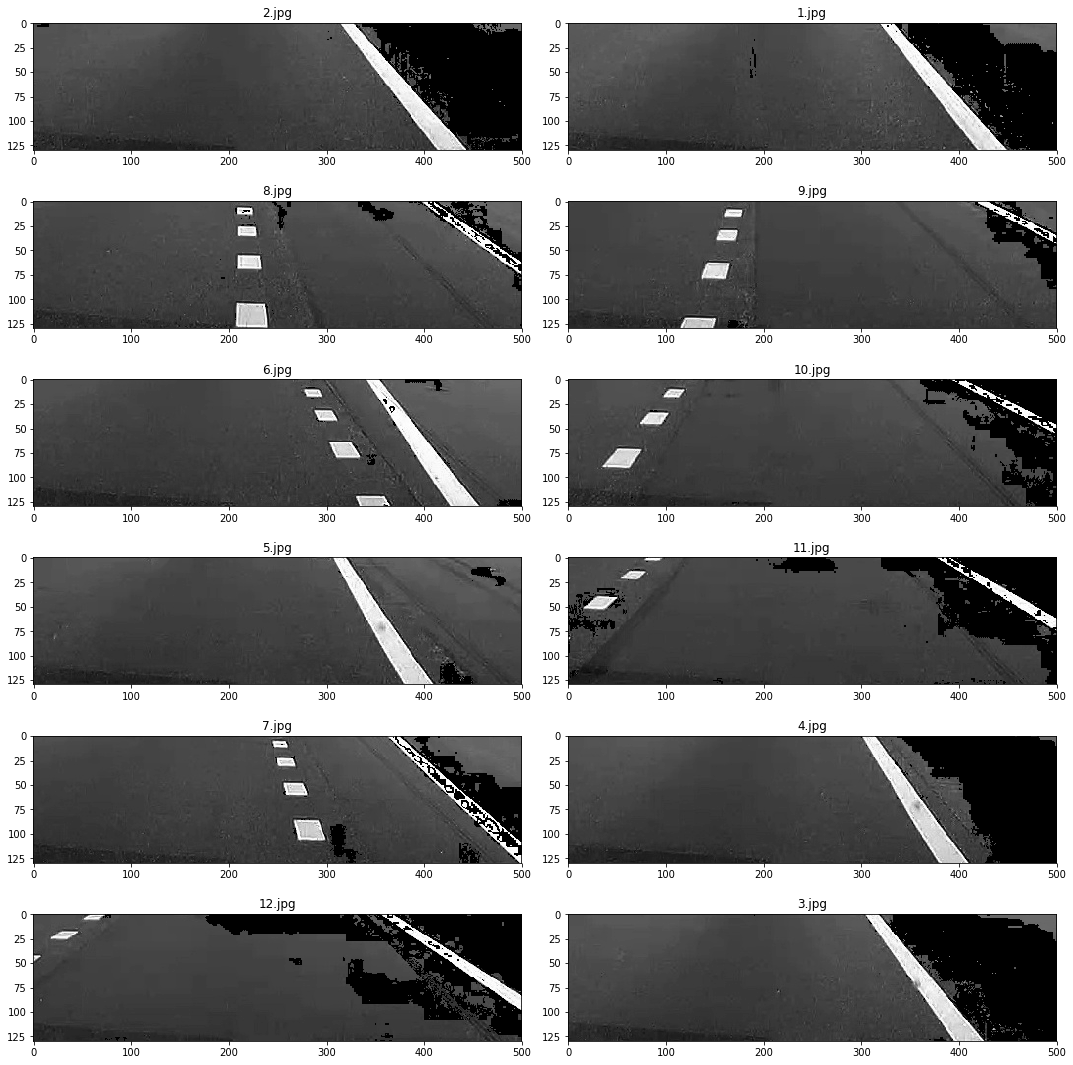

In [9]:
white_masks = []
yellow_masks = []
white_masks = [isolate_color_mask(to_hls(img), np.array([10, 10, 10], dtype=np.uint8), np.array([200, 255, 255], dtype=np.uint8)) for img in original_imgs]
yellow_masks = [isolate_color_mask(to_hls(img), np.array([170, 0, 180], dtype=np.uint8), np.array([40, 255, 255], dtype=np.uint8)) for img in original_imgs]
masked_imgs = []
for i in range(len(original_imgs)):
    mask = cv2.bitwise_or(white_masks[i], yellow_masks[i])
    masked_imgs.append(cv2.bitwise_and(darkened_imgs[i], darkened_imgs[i], mask=mask))

display_imgs(masked_imgs, test_imgs)
save_imgs(masked_imgs, test_imgs, prefix='Color_Mask')

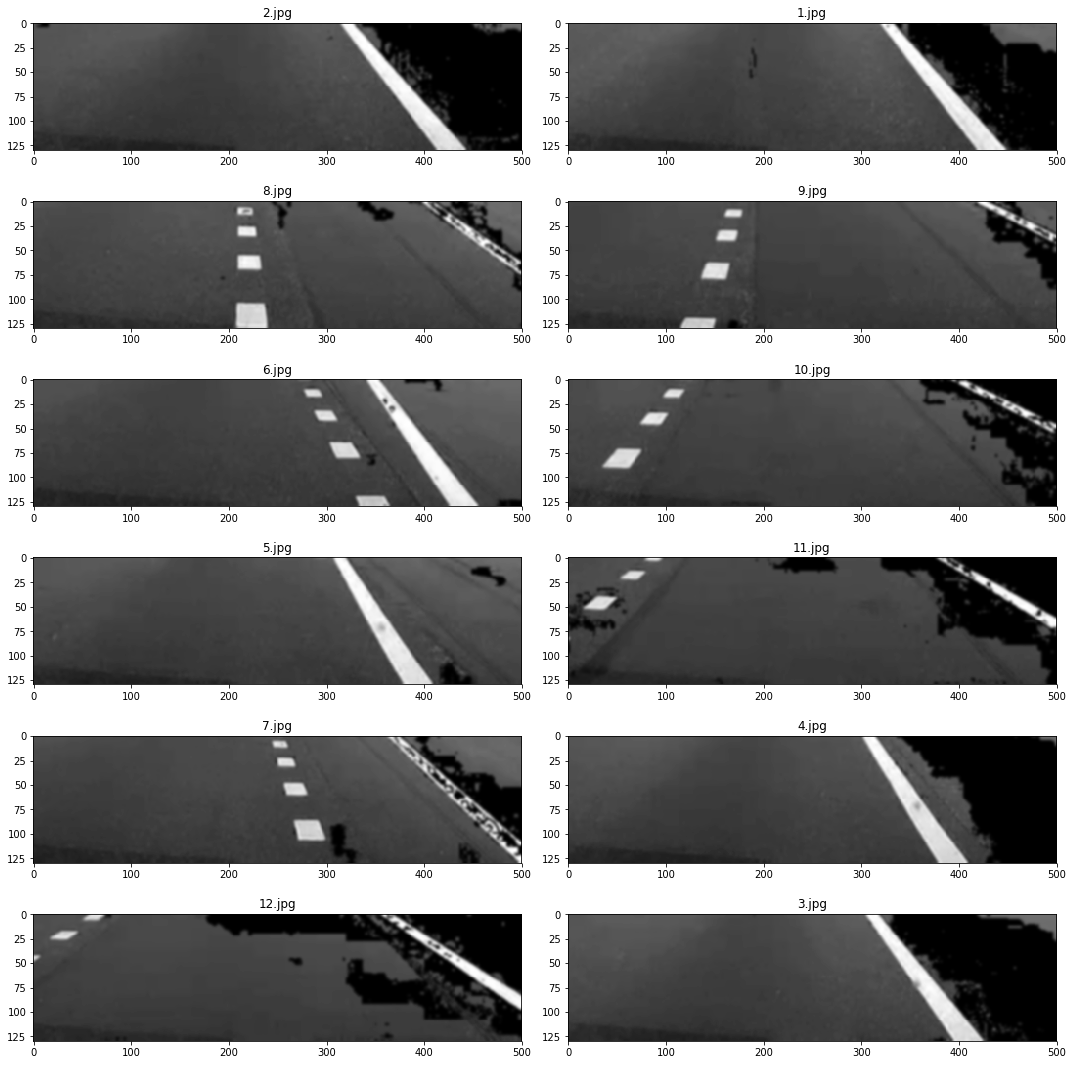

In [10]:
blurred_imgs = [gaussian_blur(img, kernel_size=7) for img in masked_imgs]
display_imgs(blurred_imgs, test_imgs)
save_imgs(blurred_imgs, test_imgs, prefix='')

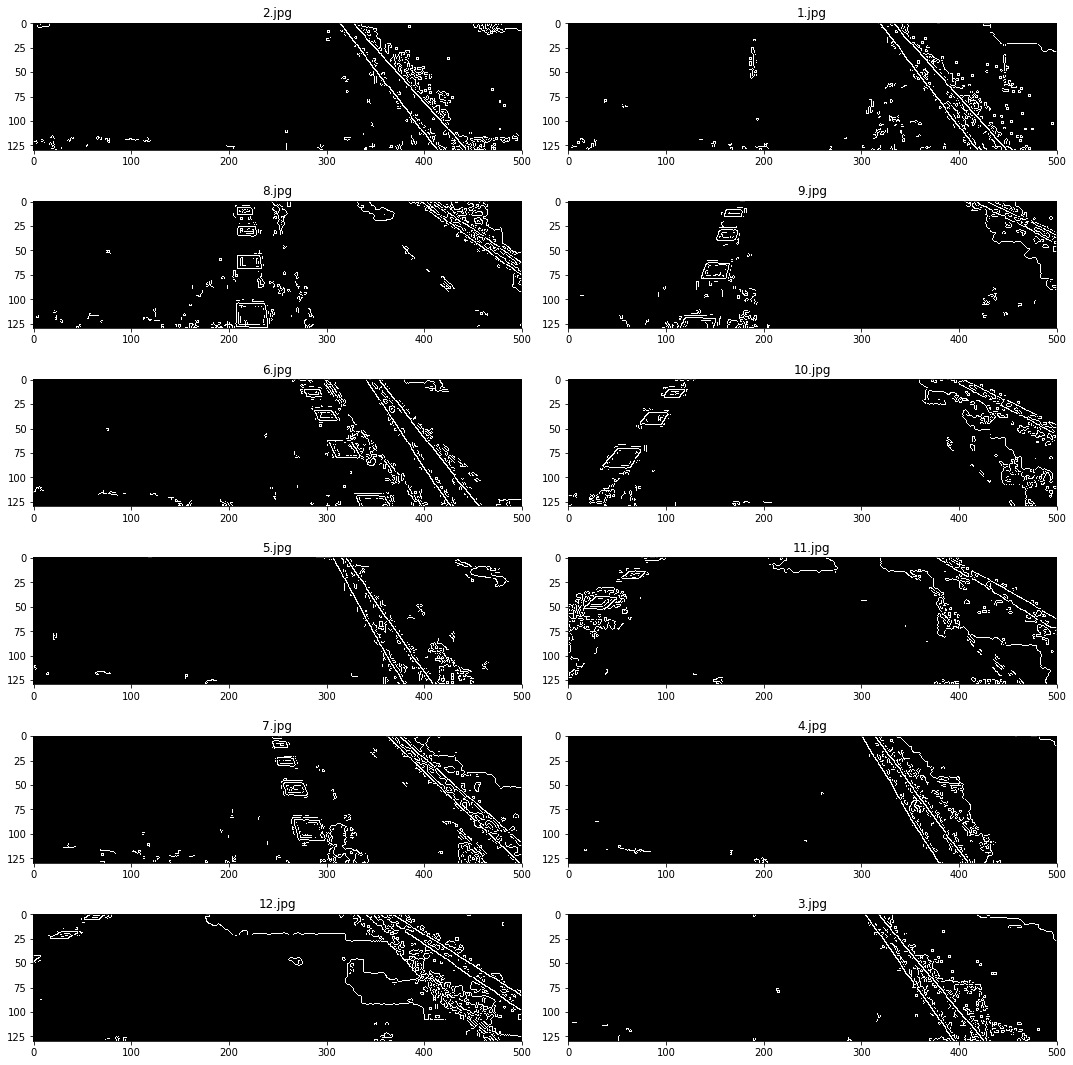

In [11]:
canny_imgs = [canny(img, low_threshold=70, high_threshold=140) for img in masked_imgs]
display_imgs(canny_imgs, test_imgs)
save_imgs(canny_imgs, test_imgs, prefix='',op_folder='cropped')

In [12]:
import numpy as np
import cv2
import os
mydir='cropped'

filelist = [ f for f in os.listdir(mydir) ]
for f in filelist:
    t=0
    image=cv2.imread("./cropped/"+f)
    height, width, chanel=image.shape
    x2=int(width/2) + 55
    x1=int(width/2) - 55
    kernel = np.ones((5,5), np.uint8) 
    cropped_image = image[ 0:height,x1:x2]
    ii = cv2.dilate(cropped_image, kernel, iterations=1)
    cv2.imwrite("./cropped/"+f, ii) 

In [13]:
import numpy as np
import cv2
import os
import operator
mydir='cropped'
dict={}
filelist = [ f for f in os.listdir(mydir) ]
for f in filelist:
    t=0
    image=cv2.imread("./cropped/"+f)
    n_white_pix = np.sum(image == 255)
    dict[f]=n_white_pix

high_px = max(dict, key=dict.get) 


In [14]:
import os
mydirs=['./cropped/','./test_imgs_output/']
for mydir in mydirs:    
    filelist = [ f for f in os.listdir(mydir) if f.endswith(".jpg") ]
    for f in filelist:
        os.remove(os.path.join(mydir, f))

In [15]:
#recognition model
import numpy as np
import cv2
from PIL import Image
import os
dirr="./video_to_frame/"
img=Image.open(dirr+high_px)
cropp=img.crop((1390,1030,1550,1070))
newsize = (400, 250) 
im1 = cropp.resize(newsize)
im1.save("./test_imgs_output/"+high_px)

In [17]:
import cv2
import numpy as np
import os, os.path
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
def character_segmentation(img_path):
    img = cv2.imread(img_path)
    im2 = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
   # cv2.imshow('in', im2)
    ret2,thresh = cv2.threshold(im2, 127, 255,cv2.THRESH_OTSU)
    ret3,thresh2 = cv2.threshold(thresh,127,255,cv2.THRESH_BINARY)
    path = os.path.join('./', 'segment') 
    #print(path)
    os.mkdir(path)
    # find contours
    im2, ctrs, hier = cv2.findContours(thresh2.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # sort contours
    sorted_ctrs = sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])
    for i, ctr in enumerate(sorted_ctrs):
        # Get bounding box
        x, y, w, h = cv2.boundingRect(ctr)
        # Getting ROI
        roi = thresh2[y:y + h, x:x + w]
        # cv2.imshow('segment no:'+str(i),roi)
        cv2.rectangle(thresh2, (x, y), (x + w, y + h), (0,0,0),1)
        # cv2.waitKey(0)
        cv2.imwrite(path+'/'+'{}.jpg'.format(i), roi)
    cv2.waitKey(0)
    return

character_segmentation("./test_imgs_output/"+high_px)


In [18]:
import os
mydirs=['./cropped/','./test_imgs_output/','./video_to_frame/']
for mydir in mydirs:    
    filelist = [ f for f in os.listdir(mydir) if f.endswith(".jpg") ]
    for f in filelist:
        os.remove(os.path.join(mydir, f))

In [19]:
import os
import glob
from PIL import Image, ImageOps
def add_border(input_image, output_image, border):
    img = Image.open(input_image)
    bimg = ImageOps.expand(img, border=border)
    bimg.save(output_image)
    

def digit_path(path):
    f=os.listdir(path)
    d=len(f)
    for i in range(0,d):
        in_img = path+str(i)+'.jpg'
        add_border(in_img, output_image=in_img, border=50)

dir1='./segment/'
digit_path(dir1)


In [685]:
path='./segment/'
num=[]
ff=os.listdir(path)
dd=len(ff)
for i in range(0,dd):
    pathp=path+str(i)+'.jpg'
    img = cv2.imread(pathp, cv2.IMREAD_GRAYSCALE)
    n_white_pix = np.sum(img == 255)
    if(n_white_pix<450):
        os.remove(pathp)

In [ ]:
import os
import glob
import cv2
import natsort 
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model
import tensorflow as tf

def load_image(filename):

    img = load_img(filename, grayscale=True, target_size=(28, 28))
    img = img_to_array(img)
    img = img.reshape(1, 28, 28, 1)
    img = img.astype('float32')
    img = img / 255.0
    return img
def run_example1(ff):

    img = load_image('/content/drive/My Drive/Colab Notebooks/segment/'+ff)
    model = load_model('/content/drive/My Drive/Colab Notebooks/cnn2.h5')
    digit = model.predict_classes(img)

    return digit[0]

mn=[]
dir='/content/drive/My Drive/Colab Notebooks/segment/'
ff=os.listdir(dir)

for i in natsort.natsorted(ff,reverse=False):
    mn.append(run_example1(i))
ll = ''.join([str(elem) for elem in mn])
ll=(str(int(str(ll)[:2]))+':'+str(int(str(ll)[2:4]))+':'+str(int(str(ll)[4:6])))
print("Time:",ll)

In [ ]:
"""
hough_lines_imgs = []
lines = []
for img in canny_imgs:
    lines.append(get_hough_lines(img))
    
for img, line in zip(original_imgs, lines):
    hough_lines_imgs.append(draw_lines(img, line))
    
display_imgs(hough_lines_imgs, test_imgs)
save_imgs(hough_lines_imgs, test_imgs, prefix='Hough')

lane_lines_imgs =[]

for img, line in zip(original_imgs, lines):
    left_lane, right_lane = get_lane_lines(img, line)
    lane_lines_imgs.append(draw_weighted_lines(img, [left_lane, right_lane], thickness= 5))
    
display_imgs(lane_lines_imgs, test_imgs)
save_imgs(lane_lines_imgs, test_imgs, prefix='Extrapolation')

"""